# 프로젝트 : 폐렴 진단기 성능개선

의료 인공지능은 다양한 분야에서 사용됩니다. 질병의 정확한 분류 또는 환자의 중증도를 확인하는 용도 등 다양한 용도로 사용됩니다.

이 중에서 현재 가장 핫한 분야는 질병을 탐지해내는 인공지능입니다. 이제 우리는 의사처럼 질병을 찾아내는 딥러닝 모델을 만들어보려고 합니다.

우리가 할 것은 폐렴(Pneumonia)을 찾아내는 딥러닝 모델을 만드는 것입니다. 폐렴에 대해서 전혀 모르신다고요? 아래에 쉽게 이해할 수 있도록 설명 해놓았으니 너무 걱정 마세요~



### 데이터셋
이번 노드에서 사용할 데이터는 캐글의 Chest X-Ray Images 입니다.

데이터의 구성은 ~/aiffel/chest_xray/data 하위에 3개의 폴더 (train, test, val)로 구성되며, 각 이미지 카테고리 (폐렴 / 정상)에 대한 하위 폴더를 포함합니다. 5,856 개의 X-Ray 이미지 (JPEG)와 2 개의 범주 (폐렴 / 정상)가 있습니다. 전체 데이터의 크기는 총 1.2GB 가량 됩니다.

(에디터 주) 캐글에서 다운로드한 데이터는 chest_xray 하위에 chest_xray 폴더가 중복으로 포함되어 있어서 전체 데이터의 크기가 2.5GB인 경우가 있습니다. 중복된 데이터는 필요하지 않습니다.

해당 이미지는 중국 광저우에 있는 광저우 여성 및 어린이 병원의 1~5 세 소아 환자의 흉부 X선 영상입니다. 

### 폐렴이란?  
폐렴(pneumonia 뉴모니아)은 폐에 염증이 생긴 상태로 중증의 호흡기 감염병이다. 세균을 통한 감염이 가장 많으며, 바이러스, 균류, 또는 기타 미생물도 원인이 될 수가 있다. 드물게는 알레르기 반응이나 자극적인 화학 물질을 흡입해 발생하기도 한다. 노인이나 어린아이, 혹은 전체적으로 상태가 안 좋은 환자들이나 기침 반사가 약한 사람들에게는 흡인성 폐렴이 발생한다. 그리고 세균이 원인인 경우는 항생제로 치료를 할 수 있다. 항생제가 생기기 전에는 50~90%가 사망할 정도로 위험한 질환이었으나, 현재는 거의 사망하지 않는다. 1940년대에 항생제가 개발되기 전까지는 폐렴 환자의 1/3 정도가 사망하였다. 오늘날에는 적절한 의학적 치료로 폐렴 환자의 95% 이상이 회복된다. 그러나 일부 저개발국(개발 도상국)에서는 폐렴이 여전히 주요 사망 원인 중 하나이다.  

### 염증  
염증은 유해한 자극에 대한 생체반응 중 하나로 면역세포, 혈관, 염증 매개체들이 관여하는 보호반응이다. 염증의 목적은 세포의 손상을 초기 단계에서 억제하고, 상처 부분의 파괴된 조직 및 괴사된 세포를 제거하며, 동시에 조직을 재생하는 것이다.  

#### 폐렴 구별법
![폐렴 사진](~/Main_Quest_01/image.png)
정상적인 흉부 X-RAY(왼쪽)는 이미지에서 비정상적인 음영 영역이 없는 깨끗한 폐를 보여줍니다.
세균성 폐렴 (가운데)은 일반적으로 오른쪽 상부 엽 (흰색 화살표)에 있는 나타내는 반면, 바이러스성 폐렴 (오른쪽)은 양쪽 폐에서보다 확산된 "interstitial(조직 사이에 있는)" 패턴으로 나타납니다.

## 1. Set-up

In [2]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

In [28]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 32
EPOCHS = 10

print(ROOT_PATH)

/aiffel/aiffel


## 2. 데이터 가져오기

In [4]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames)) #train 안 데이터 개수
print(len(test_filenames)) #test 안 데이터 개수
print(len(val_filenames)) #val 안 데이터 개수

5216
624
16


In [5]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [6]:
#train 데이터 안 정상 이미지와 폐렴 이미지
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/IM-0450-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person1345_bacteria_3422.jpeg


In [7]:
#정상 이미지 수
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")

#폐렴 이미지 수
COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1070
Pneumonia images count in training set: 3115


In [8]:
#tensorflow에서 학습시킬 때, mini-batch로 작업할 수 있도록 tf.data 인스턴스 생성
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [9]:
#Train 데이터셋 개수
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

#Validation 데이터셋 개수
VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


In [10]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

In [11]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [12]:
#train, validation 데이터 셋 구성, 데이터를 빠르게 처리하기 위해 AUTOTUNE활용
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE) 
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE) 

In [13]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


In [14]:
#test 데이터 셋 생성
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

#데이터 개수 확인
print(TEST_IMAGE_COUNT)

624


### Data augmentation

### 개선 사항
데이터 양을 증가시키고 다양한 조건에서도 적용될 수 있도록 데이터 증강을 시도하였다.

### 문제점 및 해결방안
repeat()한수로 인해서 데이터셋의 형태가 변해 버렸다. 이로 인해서 process_path 함수에서 이미지를 변환하는 decode_img 함수를 호출하여 이미지의 형상을 3차원으로 만들어주었다.

In [15]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

In [16]:
# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label


In [17]:
train_ds.take(1)

<TakeDataset shapes: ((180, 180, 3), ()), types: (tf.float32, tf.bool)>

In [18]:
def augment(img,label):
    img = tf.image.random_flip_left_right(img)  # 랜덤하게 좌우를 반전합니다.
    return img,label

In [19]:
train_ds.take(1)

<TakeDataset shapes: ((180, 180, 3), ()), types: (tf.float32, tf.bool)>

In [20]:
#tf.data 파이프라인을 사용해서 함수 정의 
#학습 데이터를 효율적으로 사용
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.map(augment, 
                num_parallel_calls=AUTOTUNE
               ) # 2개의 스레드로 병렬처리하여 데이터 증강
    ds = ds.shuffle(buffer_size=shuffle_buffer_size) # 고정 크기 버퍼를 유지하고 해당 버퍼에서 무작위로 균일하게 다음 요소를 선택
    ds = ds.repeat() # epoch를 진행하면서 여러 번 데이터셋을 사용
    ds = ds.batch(BATCH_SIZE) # BATCH_SIZE에서 정한 만큼의 배치로 주어짐
    ds = ds.prefetch(buffer_size=AUTOTUNE) # 학습하는 동안 두 번째 데이터를 CPU에서 준비할 수 있어 리소스의 유휴 상태를 줄임
    return ds

# 데이터셋 생성 및 파이프라인 설정
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

## 3. 데이터 시각화

train에 있는 batch 중 첫 번째 배치를 추출합니다.
추출된 배치를 image와 label 데이터 셋으로 나눕니다.

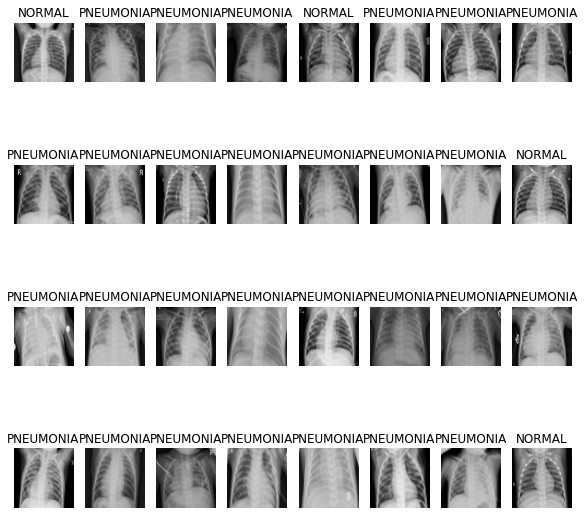

In [21]:
#이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy()) #결과 사진 출력

## 4. CNN 모델링.

### Convolution block

이미지 처리에 특화된 딥러닝 모델인 CNN을 통해 모델링을 하고 결과를 만들어 보겠습니다.
먼저, Convolution block을 만듭니다. conv_block()의 구성은 Convolution을 두 번 진행하고 Batch Normalization을 통해서 Gradient vanishing, Gradient Exploding을 해결합니다. 그리고 Max Pooling을 합니다.

### 개선사항
성능 개선을 위해서 활성화 함수 전에 배치 정규화를 적용하였다.

In [22]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation=None, padding='same'),  
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.ReLU(),
        tf.keras.layers.SeparableConv2D(filters, 3, activation=None, padding='same'),  
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.ReLU(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

### Dense Block

In [23]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation=None),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.ReLU(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

### 개선사항
더 많은 특성을 추출하기 위해서 첫 번째 Conv2D 레이어는 필터의 수를 2배로 증가시켰다. 그에 따라 conv_block 호출들에 의해 추가되는 합성곱 레이어들은 각각 64, 128, 256, 512개의 필터를 사용했다.

In [24]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(64),
        conv_block(128),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(512),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

## 5. 데이터 imbalance 처리

'Normal'과 폐렴에서 'Pneumonia' 중에 'Pneumonia' 데이터가 많이 있었죠? 한 라벨이 너무 많은 경우를 imbalance 하다고 하는데, 데이터를 학습할 때 imbalance한 데이터의 경우 학습 효과가 좋지 않을 수 있습니다.

이런 문제들을 해결하는 방법으로 Weight balancing이라는 테크닉이 사용됩니다. Weight balancing 은 training set의 각 데이터에서 loss를 계산할 때 특정 클래스의 데이터에 더 큰 loss 값을 갖도록 가중치를 부여하는 방법입니다. Keras는 model.fit()을 호출할 때 파라미터로 넘기는 class_weight 에 이러한 클래스별 가중치를 세팅할 수 있도록 지원하고 있습니다.


In [25]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0   #'Normal' 이미지에 사용할 weight 세팅
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0  #'Pneumonia' 이미지에 사용할 weight 세팅

# weight들은 'Normal'과 'Pneumonia' 전체 데이터 건수에 반비례하도록 설정
class_weight = {0: weight_for_0, 1: weight_for_1}  

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.96
Weight for PNEUMONIA: 0.67


## 6. 모델 훈련

이미지 훈련은 GPU를 사용할 것이기 때문에 먼저 GPU를 선택합니다. 모델은 위에서 만들었던 모델 함수인 build_model()을 model에 선언합니다.

이미지의 라벨이 두 개밖에 없기 때문에 "binary_cross entropy" loss를 사용합니다. optimizer로 'adam'을 사용합니다.
성과에 대해서 측정하기 위한 metrics으로 'accuracy', 'precision', 'recall'을 사용합니다.

In [26]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

### 모델 fit 진행

In [29]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/10
130/130 [==============================] - 65s 418ms/step - loss: 0.2875 - accuracy: 0.8721 - precision: 0.9679 - recall: 0.8565 - val_loss: 1.9716 - val_accuracy: 0.7334 - val_precision: 0.7334 - val_recall: 1.0000
Epoch 2/10
130/130 [==============================] - 53s 409ms/step - loss: 0.1654 - accuracy: 0.9413 - precision: 0.9811 - recall: 0.9393 - val_loss: 1.9155 - val_accuracy: 0.7344 - val_precision: 0.7344 - val_recall: 1.0000
Epoch 3/10
130/130 [==============================] - 53s 407ms/step - loss: 0.1510 - accuracy: 0.9430 - precision: 0.9831 - recall: 0.9396 - val_loss: 2.2627 - val_accuracy: 0.7344 - val_precision: 0.7344 - val_recall: 1.0000
Epoch 4/10
130/130 [==============================] - 54s 418ms/step - loss: 0.1175 - accuracy: 0.9538 - precision: 0.9846 - recall: 0.9526 - val_loss: 2.7271 - val_accuracy: 0.7363 - val_precision: 0.7363 - val_recall: 1.0000
Epoch 5/10
130/130 [==============================] - 55s 427ms/step - loss: 0.0964 - accura

## 7. 결과 확인

이제 결과를 확인해보겠습니다. 그래프로 Epochs 마다 모델의 precision, recall, accuracy, loss가 어떻게 변하는지 보여줍니다.

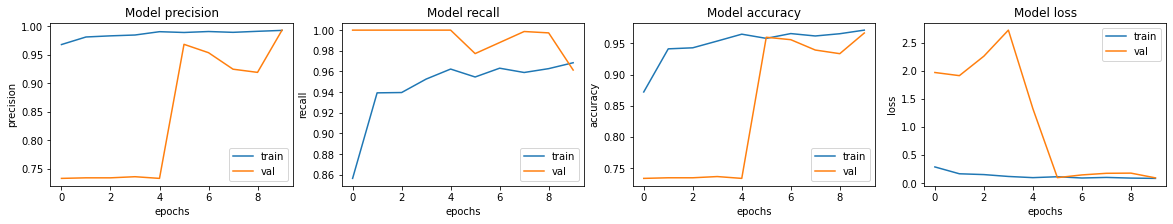

In [30]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

테스트 데이터로 모델 평가를 해보겠습니다.
모델 평가를 위해 loss, accuracy, precision, recall 값을 출력해보겠습니다.

In [31]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

20/20 [==============================] - 5s 265ms/step - loss: 0.5869 - accuracy: 0.8686 - precision: 0.8333 - recall: 0.9872
Loss: 0.5868812799453735,
Accuracy: 0.8685897588729858,
Precision: 0.8333333134651184,
Recall: 0.9871794581413269
